# Word Embeddings

## Используя предварительно обученные вложения

В общем случае вы будете обучать свою собственную модель word2vec или GloVe с нуля только в том случае, если у вас есть очень большое количество очень специализированного текста. Самый распространенный вариант использования вложений - это использование предварительно обученных вложений каким-то образом в вашей сети. Существует три основных способа использования вложений в вашей сети:

Обучить вложения с нуля
Дообучить существующие вложения из предварительно обученных моделей GloVe/word2vec
Использовать вложения из предварительно обученных моделей GloVe/word2vec
В первом варианте веса вложений инициализируются маленькими случайными значениями и обучаются с помощью обратного распространения ошибки. Вы видели это на примерах моделей skip-gram и CBOW в Keras. Это стандартный режим, когда вы используете слой вложений Keras в вашей сети.

Во втором варианте вы создаете матрицу весов из предварительно обученной модели и инициализируете веса вашего слоя вложений этой матрицей весов. Сеть будет обновлять эти веса с помощью обратного распространения ошибки, но модель будет сходиться быстрее из-за хороших начальных весов.

Третий вариант - это использование вложений слов из предварительно обученной модели и преобразование вашего ввода в векторы вложений. Затем вы можете обучать любую модель машинного обучения (то есть не обязательно даже глубокую нейронную сеть) на преобразованных данных. Если предварительно обученная модель обучена в аналогичной доменной области, как целевая доменная область, это обычно работает очень хорошо и является наименее затратным вариантом.

Для общего использования с текстами на английском языке вы можете использовать модель word2vec от Google, обученную на более чем 10 миллиардах слов из набора данных Google News. Размер словаря составляет около 3 миллионов слов, а размерность вло?usp=sharing.

Аналогично, предварительно обученную модель, обученную на 6 миллиардах токенов из английской Википедии и корпуса gigaword, можно скачать с сайта GloVe. Размер словаря составляет около 400 000 слов, и скачивание предоставляет векторы с размерностями 50, 100, 200 и 300. Размер модели составляет около 822 МБ. Вот прямая ссылка для скачивания этой модели (http://nlp.stanford. edu/data/glove.6B.zip). Более крупные модели, основанные на Common Crawl и Twitter, также доступны с того же места.

В следующих разделах мы рассмотрим, как использовать эти предварительно обученные модели тремя перечисленными способами.

In [3]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/home/gea/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


### Обучение вложений с нуля
В этом примере мы будем обучать одномерную сверточную нейронную сеть (CNN) для классификации предложений на позитивные или негативные. Вспомните, что CNN используют пространственную структуру изображений, обеспечивая локальную связность между нейронами соседних слоев.

Слова в предложениях имеют линейную структуру так же, как изображения имеют пространственную структуру. Традиционные (не глубокие обучения) подходы NLP к моделированию языка включают создание словесных n-грма), чтобы использовать эту врожденную линейную структуру между словами. Одномерные CNN делают нечто подобное, обучая сверточные фильтры, которые работают с предложениями по несколько слов за раз, и применяют максимальное объединение результатов для создания вектора, который представляет наиболее важные идеи в предложении.

Есть еще один класс нейронных сетей, называемый рекуррентной нейронной сетью (RNN), который специально разработан для работы с последовательными данными, включая текст, который является последовательностью слов. Обработка в RNN отличается от обработки в CNN. Мы узнаем о RNN в будущей главе.

В нашей примерной сети входной текст преобразуется в последовательность индексов слов. Обратите внимание, что мы использовали инструментарий естественного языка (NLTK) для разбора текста на предложения и слова. Мы также могли использовать регулярные выражения для этого, но статистические модели, предоставляемые NLTK, более мощные для разбора, чем регулярные выражения. Если вы работаете с вложениями слов, то очень вероятно, что вы также работаете с NLP, в этом случае у вас уже должен быть установлен NLTK.

Эта ссылка (http://www.nltk.org/install.html) содержит информацию, которая поможет вам установить NLTK на ваш компьютер. Вам также понадобится установить данные NLTK, которые представляют собой некоторые обученные корпуса, которые идут в комплекте с NLTK. Инструкции по установке данных NLTK доступны здесь: http://www.nl tk.org/data.html.

Последовательность индексов слов подается в массив слоев вложений фиксированного размера (в нашем случае, количество слов в самом длинном предложении). Слой вложений по умолчанию инициализируется случайными значениями. Выход слоя вложений подключается к одномерному сверточному слою, который свертывает (в нашем примере) триграммы слов 256 различными способами (по сути, он применяет различные изученные линейные комбинации весов на вложениях слов). Эти признаки затем объединяются в одно объединенное слово с помощью слоя глобального максимального объединения. Этот вектор (256) затем вводится в плотный слой, который выводит вектор (2). Активация softmax вернет пару вероятностей, одна соответствует позитивному настроению, а другая - негативному настроению. Сеть показана на следующем рисунке:

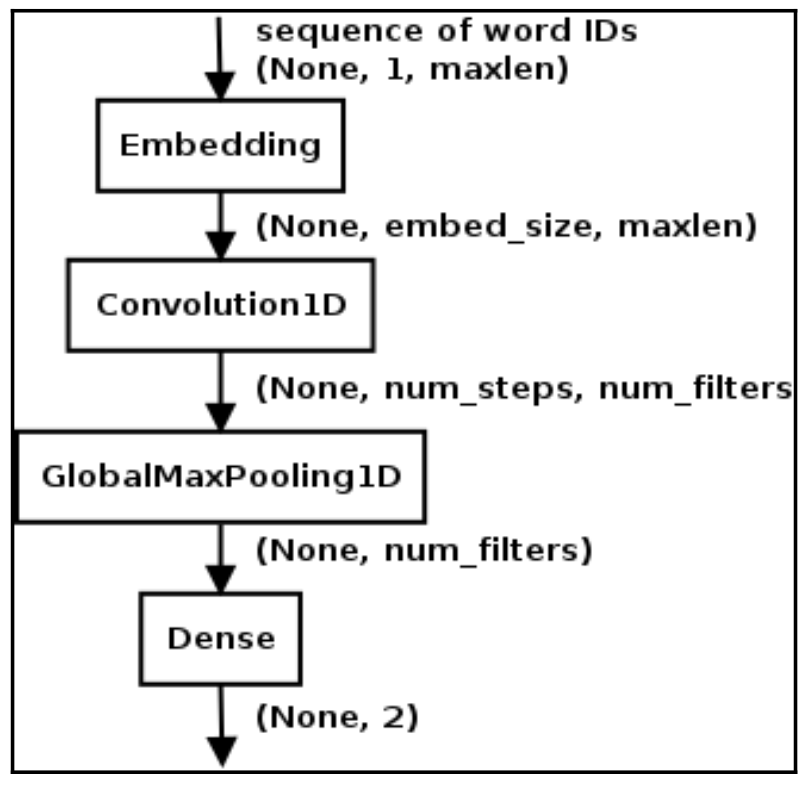

In [4]:
from IPython.display import Image
Image(filename='images/learn_embeddings_from_scratch.png', width=400)

Давайте посмотрим, как это можно закодировать с использованием Keras. Сначала мы объявляем наши импорты. Сразу после констант вы заметите, что я устанавливаю значение random.seed равным 42. Это сделано для того, чтобы результаты были согласованными между запусками. Поскольку инициализация матриц весов является случайной, различия в инициализации могут привести к различиям в выводе, поэтому это один из способов контроля над этим:

In [9]:
import numpy as np
import pandas as pd

import collections
import re
import nltk

from tensorflow.keras.layers import Dense, Dropout, Conv1D, Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


In [10]:
import tensorflow as tf
tf.test.gpu_device_name()

2023-11-13 16:48:05.537871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


''

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
pd.set_option("display.max_colwidth", 500)

In [13]:
np.random.seed(42)
random_state = 42

In [14]:
train_df  = pd.read_table('data/UMICH_SI650_train_data.txt', names=['sentiment', 'comment'], header=None, delimiter="\t", quoting=3)
test_df  = pd.read_table('data/UMICH_SI650_test_data.txt', names=['comment'], header=None, delimiter="\t", quoting=3)

In [21]:
train_df

,sentiment,comment
0,1,The Da Vinci Code book is just awesome.
1,1,"this was the first clive cussler i've ever read, but even books like Relic, and Da Vinci code were more plausible than this."
2,1,i liked the Da Vinci Code a lot.
3,1,i liked the Da Vinci Code a lot.
4,1,I liked the Da Vinci Code but it ultimatly didn't seem to hold it's own.
...,...,...
7081,0,Brokeback Mountain was boring.
7082,0,So Brokeback Mountain was really depressing.
7083,0,"As I sit here, watching the MTV Movie Awards, I am reminded of how much I despised the movie Brokeback Mountain."
7084,0,Ok brokeback mountain is such a horrible movie.


In [16]:
test_df.head(5)

,comment
0,""" I don't care what anyone says, I like Hillary Clinton."
1,have an awesome time at purdue!..
2,"Yep, I'm still in London, which is pretty awesome: P Remind me to post the million and one pictures that I took when I get back to Markham!..."
3,"Have to say, I hate Paris Hilton's behavior but I do think she's kinda cute.."
4,i will love the lakers.


In [17]:
# Inspect how many are positive and negative sentiments
train_df.sentiment.value_counts()

sentiment
1    3995
0    3091
Name: count, dtype: int64

/home/gea/anaconda3/envs/TensorF/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gea/anaconda3/envs/TensorF/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gea/anaconda3/envs/TensorF/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


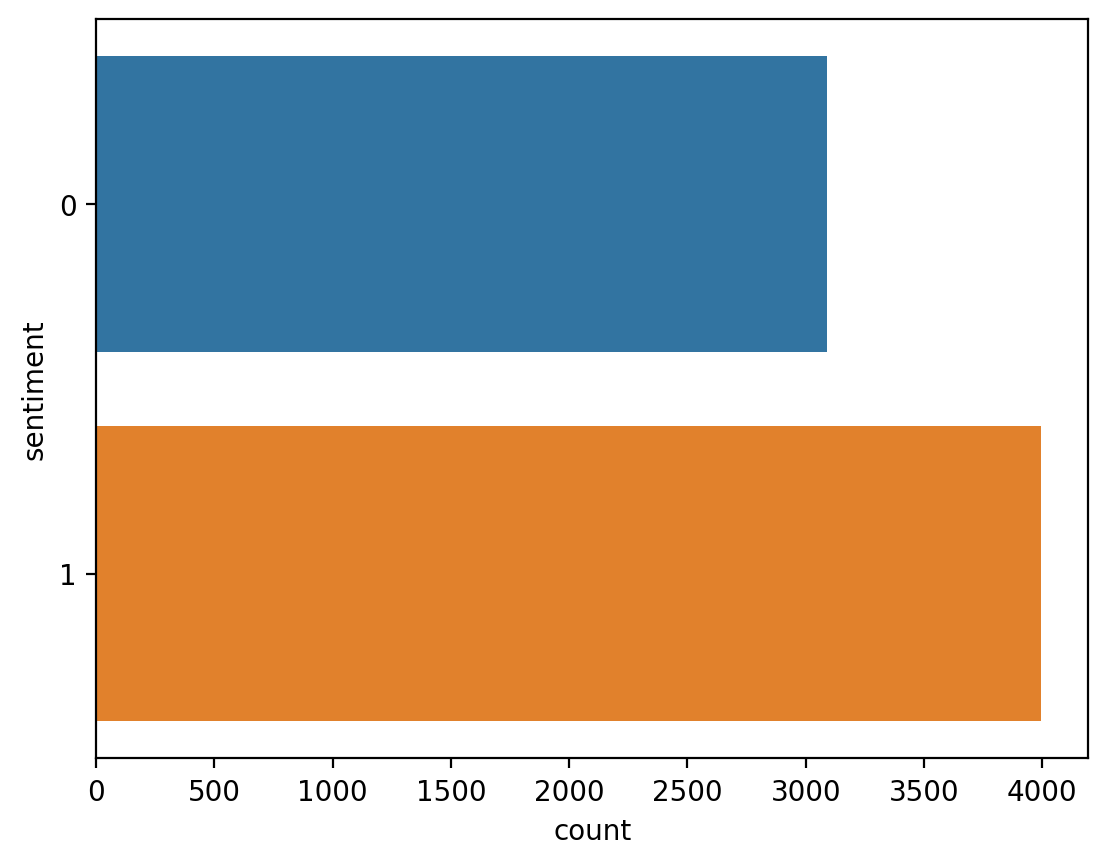

In [18]:
sns.countplot(y='sentiment', data=train_df);

In [22]:
# How many records in all in the training set
len(train_df)

7086

Мы объявляем наши константы. Для всех последующих примеров мы будем классифицировать предложения из конкурса по классификации сентиментов UMICH SI650 на Kaggle. Набор данных содержит около 7 000 предложений и помечен 1 для позитивных и 0 для негативных. INPUT_FILE определяет путь к этому файлу с предложениями и метками. Формат файла — это метка сентимента (0 или 1), за которой следует табуляция, за которой следует предложение.

Настройка VOCAB_SIZE указывает, что мы будем учитывать только первые 5 000 токенов в тексте. Настройка EMBED_SIZE — это размер вложения, который будет сгенерирован слоем вложений в сети. NUM_FILTERS — это количество сверточных фильтров, которое мы будем обучать для нашего сверточного слоя, а NUM_WORDS — это размер каждого фильтра, то есть сколько слов мы будем свертывать за раз. BATCH_SIZE и NUM_EPOCHS — это количество записей для подачи в сеть за один раз и сколько раз мы будем проходить через весь набор данных во время обучения:

In [23]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"
VOCAB_SIZE  = 5000
EMBED_SIZE  = 100
NUM_FILTERS = 256
NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 20

В следующем блоке мы сначала читаем наши входные предложения и составляем наш словарь из наиболее часто встречающихся слов в корпусе. Затем мы используем этот словарь, чтобы преобразовать наши входные предложения в список индексов слов:

In [24]:
maxlen = 0
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [25]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

Мы дополняем каждое из наших предложений до предопределенной длины maxlen (в данном случае это количество слов в самом длинном предложении в тренировочном наборе). Мы также преобразуем наши метки в категориальный формат с использованием служебной функции Keras. Последние два шага являются стандартным рабочим процессом для обработки текстового ввода, который мы будем видеть снова и снова:

In [26]:
xs, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [27]:
from tensorflow.keras.utils import to_categorical

X = pad_sequences(xs, maxlen=maxlen)
y = to_categorical(ys)

Наконец, мы разделяем наши данные на обучающую и тестовую выборки в соотношении 70/30. Теперь данные подготовлены и могут быть поданы в сеть:

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

Мы определяем сеть, которую описали ранее в этом уроке:




In [29]:
from tensorflow.keras.layers import SpatialDropout1D

def create_model(initial_weights=None, trainable=True):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_sz, 
                    output_dim=EMBED_SIZE, 
                    input_length=maxlen, 
                    weights=initial_weights,
                    trainable=trainable))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(filters=NUM_FILTERS, kernel_size=NUM_WORDS, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(2, activation='softmax'))
    return model

In [30]:
model = create_model()

2023-11-13 16:52:39.006647: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [31]:
# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           199400    
                                                                 
 spatial_dropout1d (SpatialD  (None, 22, 100)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 20, 256)           77056     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 276,970
Trainable params: 276,970
Non-trai

In [47]:
# plot graph
import pydot
from keras.utils import plot_model
plot_model(model, to_file='images/model_learn_embeddings_from_scratch.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


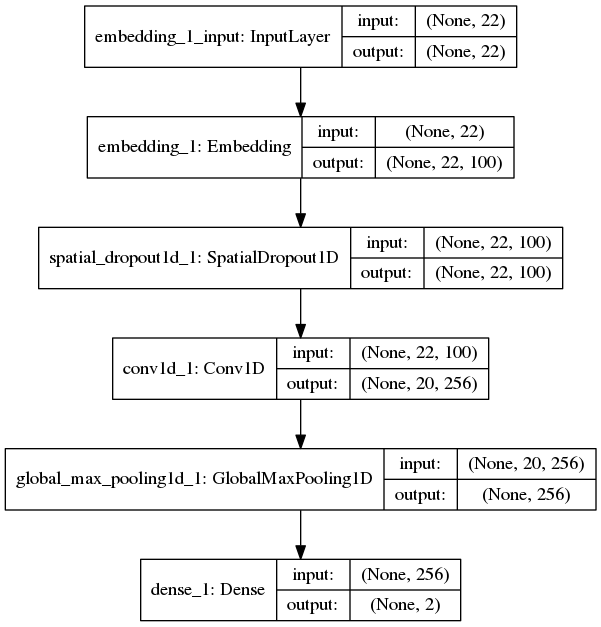

In [33]:
from IPython.display import Image
Image(filename='images/model_learn_embeddings_from_scratch.png')

Затем мы компилируем модель. Поскольку наша цель бинарна (позитивная или негативная), мы выбираем categorical_crossentropy в качестве функции потерь. В качестве оптимизатора мы выбираем adam. После этого мы обучаем модель, используя наш обучающий набор данных, с размером батча 64 и обучаем в течение 20 эпох:

In [34]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Epoch 1/20
78/78 [==============================] - 3s 28ms/step - loss: 0.2467 - accuracy: 0.9300 - val_loss: 0.0281 - val_accuracy: 0.9882
Epoch 2/20
78/78 [==============================] - 2s 27ms/step - loss: 0.0129 - accuracy: 0.9956 - val_loss: 0.0157 - val_accuracy: 0.9962
Epoch 3/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0124 - val_accuracy: 0.9934
Epoch 4/20
78/78 [==============================] - 2s 30ms/step - loss: 0.0022 - accuracy: 0.9996 - val_loss: 0.0119 - val_accuracy: 0.9948
Epoch 5/20
78/78 [==============================] - 2s 29ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0127 - val_accuracy: 0.9962
Epoch 6/20
78/78 [==============================] - 2s 28ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 0.0112 - val_accuracy: 0.9939
Epoch 7/20
78/78 [==============================] - 2s 31ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0132 - val_accuracy: 0.9953
Epoch 8/20
78

In [37]:
history.history

{'loss': [0.24673666059970856,
  0.012921791523694992,
  0.0038700357545167208,
  0.0021933468524366617,
  0.001433198107406497,
  0.0010181124089285731,
  0.0011014221236109734,
  0.0010817829752340913,
  0.0017956012161448598,
  0.0006566671654582024,
  0.0012202666839584708,
  0.0007560500525869429,
  0.000989780412055552,
  0.0011103515280410647,
  0.000651417241897434,
  0.001652588602155447,
  0.0006772318156436086,
  0.0009369783801957965,
  0.0005807915586046875,
  0.0011805635876953602],
 'accuracy': [0.9300402998924255,
  0.9955645203590393,
  0.9995967745780945,
  0.9995967745780945,
  0.9997983574867249,
  0.9997983574867249,
  0.9997983574867249,
  0.9997983574867249,
  0.9995967745780945,
  0.9997983574867249,
  0.9995967745780945,
  0.9997983574867249,
  0.9997983574867249,
  0.9997983574867249,
  0.9997983574867249,
  0.9995967745780945,
  0.9997983574867249,
  0.9995967745780945,
  0.9995967745780945,
  0.9997983574867249],
 'val_loss': [0.028124716132879257,
  0.01573

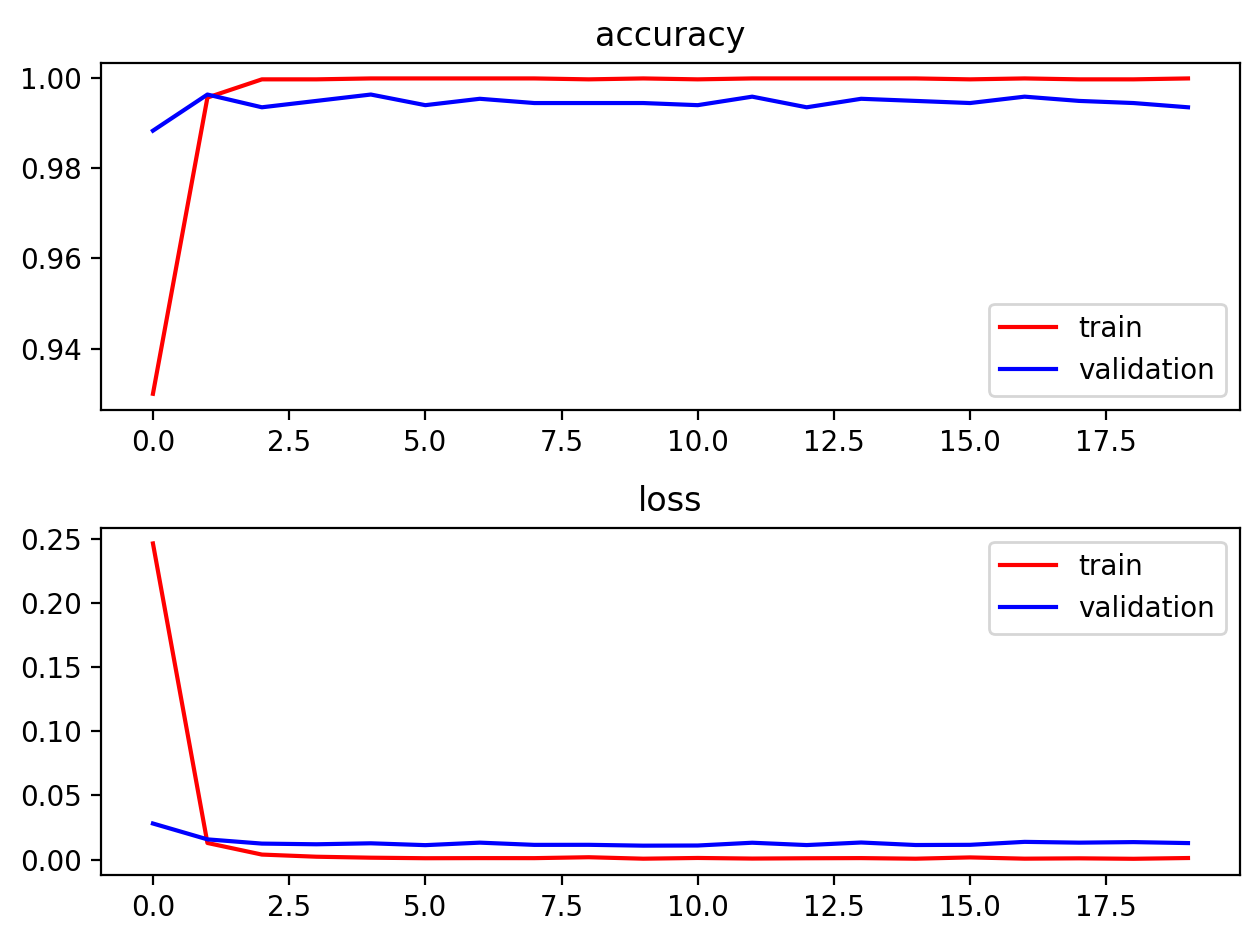

In [38]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [39]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.013, accuracy: 0.993


## Дообучение существующих вложений из word2vec
В этом примере мы будем использовать ту же сеть, что и для обучения наших вложений с нуля. В коде основное отличие — это дополнительный блок кода для загрузки модели word2vec и создания матрицы весов для слоя вложений.

Как всегда, мы начинаем с импорта и установки случайного зерна для повторяемости. Помимо ранее увиденных импортов, есть дополнительный для импорта модели word2vec из gensоторую мы создали в предыдущем блоке:







In [48]:
import numpy as np
import pandas as pd

import collections
import re
import nltk  # It's good practice to import libraries separately

# Keras layers and model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Embedding, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical  # np_utils.to_categorical is now to_categorical

# Gensim for word2vec model
from gensim.models import KeyedVectors

# Scikit-learn for splitting the dataset
from sklearn.model_selection import train_test_split

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt


In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [50]:
pd.set_option("display.max_colwidth", 500)

In [51]:
np.random.seed(42)
random_state = 42

Далее идет настройка констант. Единственное отличие здесь в том, что мы уменьшили значение NUM_EPOCHS с 20 до 10. Напомним, что инициализация матрицы значениями из предварительно обученной модели обычно приводит к хорошим значениям, которые сходятся быстрее:

In [73]:
INPUT_FILE     = "data/UMICH_SI650_train_data.txt"
WORD2VEC_MODEL = "data/GoogleNews-vectors-negative300.bin.gz"
VOCAB_SIZE     = 5000
EMBED_SIZE     = 300
NUM_FILTERS    = 256
NUM_WORDS      = 3
BATCH_SIZE     = 64
NUM_EPOCHS     = 10

Следующий блок извлекает слова из набора данных и создает словарь наиболее часто встречающихся терминов, затем анализирует набор данных снова, чтобы создать список дополненных списков слов. Также он преобразует метки в категориальный формат. Наконец, он разделяет данные на обучающую и тестовую выборки. Этот блок идентичен предыдущему примеру и был подробно объяснен там:

In [53]:
maxlen = 0
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [54]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [55]:
xs, ys = [], []
with open(file='data/UMICH_SI650_train_data.txt', mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [56]:
X = pad_sequences(xs, maxlen=maxlen)
y = to_categorical(ys)

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [58]:
TEST_FILE  = "data/UMICH_SI650_test_data.txt"

In [59]:
xs = []
with open(file=TEST_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    wids = []
    for sentence in fin:
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if word in word2index:
            wids.append(word2index[word])
        xs.append(np.array(wids))

In [60]:
X_test = pad_sequences(xs, maxlen=maxlen)

Следующий блок загружает модель word2vec из предварительно обученной модели. Эта модель обучена на примерно 10 миллиардах слов статей Google News и имеет размер словаря 3 миллиона. Мы загружаем её и ищем векторы вложения для слов из нашего словаря, и записываем вектор вложения в нашу матрицу весов word2vec_embedding_weights. Строки этой матрицы весов соответствуют словам в словаре, а столбцы каждой строки составляют вектор вложения для слова.

Размеры матрицы word2vec_embedding_weights — это vocab_sz и EMBED_SIZE. Размер vocab_sz на единицу больше, чем максимальное количество уникальных терминов в словаре, дополнительный псевдо-токен UNK представляет слова, которых нет в словаре.

Обратите внимание, что некоторые слова из нашего словаря могут отсутствовать в модели word2vec Google News, поэтому когда мы сталкиваемся с такими словами, векторы вложения для них остаются по умолчанию со значением всех нулей:

In [68]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

In [67]:
wv

In [62]:
vec_king

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [102]:
# load word2vec model
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)
word2vec_embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
for word, index in word2index.items():
    try:
        word2vec_embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass


ValueError: invalid literal for int() with base 10: '{"payload":{"allShortcutsEnabled":true,"fileTree":{"":{"items":[{"name":".gitattributes","path":".gitattributes","contentType":"file"},{"name":"GoogleNews-vectors-negative300.bin.gz","path":"GoogleNe

Мы определяем нашу сеть. Отличие этого блока от нашего предыдущего примера заключается в том, что мы инициализируем веса слоя вложения матрицей word2vec_embedding_weights, которую мы создали в предыдущем блоке:

In [66]:
model = create_model(initial_weights=[word2vec_embedding_weights], trainable=True)

NameError: name 'word2vec_embedding_weights' is not defined

We then compile our model with the categorical cross-entropy loss function and the Adam optimizer, and train the network with batch size 64 and for 10 epochs, then evaluate the trained model:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

In [ ]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [ ]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

The model gives us an accuracy of 99.4% on the test set after 10 epochs of training. In the previous example, we got an accuracy of 99.6% accuracy after 20 epochs.

In [ ]:
# make predictions
y_pred = model.predict_classes(X_test)

In [ ]:
# How many negative and positive classes
pd.Series(y_pred).value_counts()

In [ ]:
# Let's sample some of the predictions
import random
sample = random.sample(range(len(test_df)), 15)

for sentiment, comment in zip(y_pred[sample], test_df.loc[sample].comment):
    print(sentiment, comment)

## Fine-tuning learned embeddings from GloVe

Fine tuning using pre-trained GloVe embeddings is very similar to fine tuning using pre- trained word2vec embeddings. In fact, all of the code, except for the block that builds the weight matrix for the embedding layer, is identical. Since we have already seen this code twice, I will just focus on the block of code that builds the weight matrix from the GloVe embeddings.

GloVe embeddings come in various flavors. We use the model pre-trained on 6 billion tokens from the English Wikipedia and the gigaword corpus. The vocabulary size for the model is about 400,000, and the download provides vectors of dimensions 50, 100, 200, and 300. We will use embeddings from the 300 dimensional model.

In [79]:
import numpy as np
import pandas as pd

import collections

import re, nltk

import keras
from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [89]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"
GLOVE_MODEL = "data/glove.6B.300d.txt"
VOCAB_SIZE  = 5000
EMBED_SIZE  = 300
NUM_FILTERS = 256
NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 10

In [81]:
maxlen = 0
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [82]:
word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [83]:
xs, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        xs.append(wids)

In [86]:
X = pad_sequences(xs, maxlen=maxlen)
y = keras.utils.np_utils.to_categorical(ys)

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

The only thing we need to change in the code for the previous example is to replace the block that instantiated a word2vec model and loaded the embedding matrix using the following block of code. If we use a model with vector size other than 300, then we also need to update `EMBED_SIZE`.

The vectors are provided in space-delimited text format, so the first step is to read the code into a dictionary, `word2emb`. This is analogous to the line instantiating the Word2Vec model in our previous example:

In [90]:
# load GloVe vectors
word2emb = {}
with open(GLOVE_MODEL, "rb") as fglove:
    for line in fglove:
        cols = line.strip().split()
        word = cols[0]
        embedding = np.array(cols[1:], dtype="float32")
        word2emb[word] = embedding

We then instantiate an embedding weight matrix of size (`vocab_sz` and `EMBED_SIZE`) and populate the vectors from the `word2emb` dictionary. Vectors for words that are found in the vocabulary but not in the GloVe model remain set to all zeros:

In [91]:
glove_embedding_weights = np.zeros((vocab_sz, EMBED_SIZE))
for word, index in word2index.items():
    try:
        glove_embedding_weights[index, :] = word2emb[word]
    except KeyError:
        pass

In [92]:
model = create_model(initial_weights=[glove_embedding_weights], trainable=True)

In [93]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [94]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Epoch 1/10
78/78 [==============================] - 4s 41ms/step - loss: 0.6910 - accuracy: 0.5575 - val_loss: 0.6880 - val_accuracy: 0.5701
Epoch 2/10
78/78 [==============================] - 3s 38ms/step - loss: 0.6879 - accuracy: 0.5611 - val_loss: 0.6857 - val_accuracy: 0.5701
Epoch 3/10
78/78 [==============================] - 3s 44ms/step - loss: 0.6864 - accuracy: 0.5611 - val_loss: 0.6844 - val_accuracy: 0.5701
Epoch 4/10
78/78 [==============================] - 3s 44ms/step - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6838 - val_accuracy: 0.5701
Epoch 5/10
78/78 [==============================] - 3s 40ms/step - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6837 - val_accuracy: 0.5701
Epoch 6/10
78/78 [==============================] - 3s 40ms/step - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 7/10
78/78 [==============================] - 3s 40ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 8/10
78

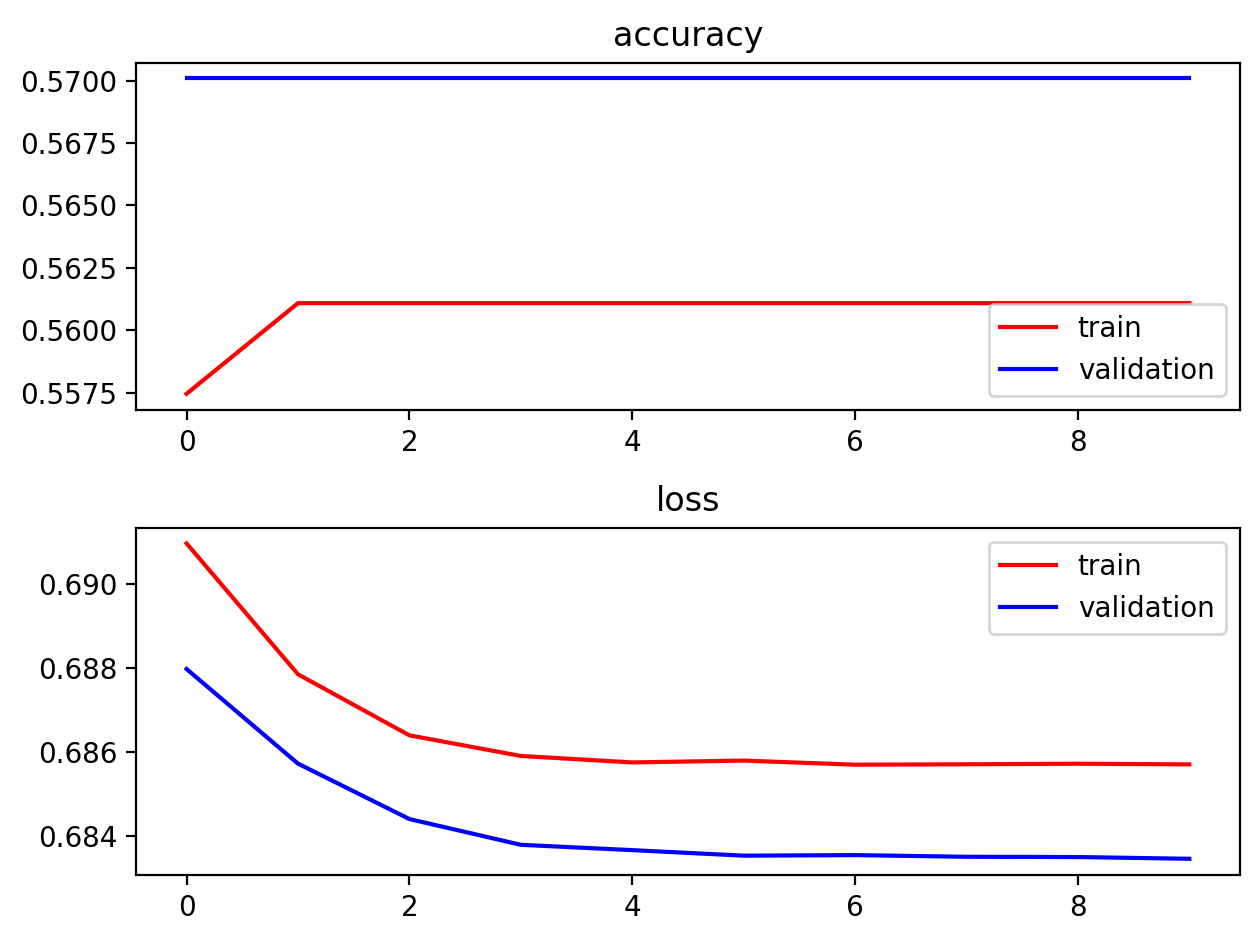

In [96]:
# plot loss function
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
#plt.show()

In [97]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.683, accuracy: 0.570


This gives us 57.0% accuracy in 10 epochs, which is not at all as good as the results we got from fine-tuning the network using word2vec embedding_weights.

## Transfer Learning: Look up embeddings

Our final strategy is to look up embeddings from pre-trained networks. The simplest way to do this with the current examples is to just set the `trainable` parameter of the embedding layer to `False`. This ensures that backpropagation will not update the weights on the embedding layer:

In [98]:
VOCAB_SIZE  = 5000
EMBED_SIZE  = 300
NUM_FILTERS = 256
NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 10

In [103]:
model = create_model(initial_weights=[word2vec_embedding_weights], trainable=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, 
                epochs=NUM_EPOCHS, 
                validation_data=(X_valid, y_valid), 
                shuffle=True)
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Epoch 1/10
78/78 [==============================] - 3s 32ms/step - loss: 0.6909 - accuracy: 0.5550 - val_loss: 0.6880 - val_accuracy: 0.5701
Epoch 2/10
78/78 [==============================] - 2s 28ms/step - loss: 0.6876 - accuracy: 0.5611 - val_loss: 0.6853 - val_accuracy: 0.5701
Epoch 3/10
78/78 [==============================] - 2s 29ms/step - loss: 0.6863 - accuracy: 0.5611 - val_loss: 0.6842 - val_accuracy: 0.5701
Epoch 4/10
78/78 [==============================] - 3s 33ms/step - loss: 0.6859 - accuracy: 0.5611 - val_loss: 0.6838 - val_accuracy: 0.5701
Epoch 5/10
78/78 [==============================] - 3s 32ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6836 - val_accuracy: 0.5701
Epoch 6/10
78/78 [==============================] - 3s 32ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 7/10
78/78 [==============================] - 3s 33ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6836 - val_accuracy: 0.5701
Epoch 8/10
78

In [104]:
model = create_model(initial_weights=[glove_embedding_weights], trainable=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, 
                batch_size=BATCH_SIZE, 
                epochs=NUM_EPOCHS, 
                validation_data=(X_valid, y_valid), 
                shuffle=True)
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Epoch 1/10
78/78 [==============================] - 3s 31ms/step - loss: 0.6904 - accuracy: 0.5607 - val_loss: 0.6875 - val_accuracy: 0.5701
Epoch 2/10
78/78 [==============================] - 2s 28ms/step - loss: 0.6873 - accuracy: 0.5611 - val_loss: 0.6851 - val_accuracy: 0.5701
Epoch 3/10
78/78 [==============================] - 2s 31ms/step - loss: 0.6862 - accuracy: 0.5611 - val_loss: 0.6841 - val_accuracy: 0.5701
Epoch 4/10
78/78 [==============================] - 2s 30ms/step - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6838 - val_accuracy: 0.5701
Epoch 5/10
78/78 [==============================] - 2s 32ms/step - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6836 - val_accuracy: 0.5701
Epoch 6/10
78/78 [==============================] - 2s 30ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 7/10
78/78 [==============================] - 2s 30ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 8/10
78

Setting this value with the word2vec and GloVe examples gave us accuracies of 57.0% and 99.5% respectively after 10 epochs of training.

### Transfer Learning: Look up embeddings from Glove

However, in general, this is not how you would use pre-trained embeddings in your code. Typically, it involves preprocessing your dataset to create word vectors by looking up words in one of the pre-trained models, and then using this data to train some other model. The second model would not contain an Embedding layer, and may not even be a deep learning network.

The following example describes a dense network that takes as its input a vector of size 100, representing a sentence, and outputs a 1 or 0 for positive or negative sentiment. Our dataset is still the one from the UMICH S1650 sentiment classification competition with around 7,000 sentences.

As previously, large parts of the code are repeated, so we only explain the parts that are new or otherwise need explanation.

We begin with the imports, set the random seed for repeatability, and set some constant values. In order to create the 100-dimensional vectors for each sentence, we add up the GloVe 100-dimensional vectors for the words in the sentence, so we choose the glove.6B.100d.txt file:

In [107]:
import numpy as np
import pandas as pd

import collections

import re, nltk

from keras.layers.core import Dense, Dropout, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers import Embedding
from keras.layers.pooling import GlobalMaxPooling1D
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

# Visualization
import seaborn as sns

# this allows plots to appear directly in the notebook
import matplotlib.pyplot as plt

In [108]:
np.random.seed(42)
random_state = 42

In [111]:
INPUT_FILE  = "data/UMICH_SI650_train_data.txt"
GLOVE_MODEL = "data/glove.6B.100d.txt"
VOCAB_SIZE  = 5000
EMBED_SIZE  = 100
#NUM_FILTERS = 256
#NUM_WORDS   = 3
BATCH_SIZE  = 64
NUM_EPOCHS  = 10

The next block reads the sentences and creates a word frequency table. From this, the most common 5,000 tokens are selected and lookup tables (from word to word index and back) are created. In addition, we create a pseudo-token `_UNK_` for tokens that do not exist in the vocabulary. Using these lookup tables, we convert each sentence to a sequence of word IDs, padding these sequences so that all sequences are of the same length (the maximum number of words in a sentence in the training set). We also convert the labels to categorical format:

In [112]:
maxlen = 0
counter = collections.Counter()
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            counter[word] += 1

In [113]:
# creating vocabulary
word2index = collections.defaultdict(int)
word2index["_UNK_"] = 0
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_sz = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}
index2word[0] = "_UNK_"

In [114]:
# creating word sequences
ws, ys = [], []
with open(file=INPUT_FILE, mode='r', encoding='utf-8') as fin:
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for line in fin:
        label, sentence = line.strip().split('\t')
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        ys.append(int(label))
        words = [token.lower() for token in nltk.word_tokenize(sentence) if not token.lower() in stop_words]
        wids = [word2index[word] for word in words]
        ws.append(wids)

In [115]:
words = [index2word[wid] for wid in ws[0]]
words

['da', 'vinci', 'code', 'book', 'awesome']

In [118]:
W = pad_sequences(ws, maxlen=maxlen)
y = keras.utils.np_utils.to_categorical(ys)

We load the GloVe vectors into a dictionary. If we wanted to use word2vec here, all we have to do is replace this block with a gensim `KeyedVectors.load_word2vec_format()` call and replace the following block to look up the word2vec model instead of the word2emb dictionary:

In [119]:
# load GloVe vectors
word2emb = {}
with open(GLOVE_MODEL, "rb") as fglove:
    for line in fglove:
        cols = line.strip().split()
        word = cols[0]
        embedding = np.array(cols[1:], dtype="float32")
        word2emb[word] = embedding

The next block looks up the words for each sentence from the word ID matrix W and populates a matrix E with the corresponding embedding vector. These embedding vectors are then added to create a sentence vector, which is written back into the X matrix. The output of this code block is the matrix `X` of size (`num_records` and `EMBED_SIZE`):

In [120]:
# transferring glove embeddings
X = np.zeros((W.shape[0], EMBED_SIZE))
for i in range(W.shape[0]):
    E = np.zeros((EMBED_SIZE, maxlen))
    words = [index2word[wid] for wid in W[i].tolist()]
    for j in range(maxlen):
        try:
            E[:, j] = word2emb[words[j]]
        except KeyError:
            pass
    X[i, :] = np.sum(E, axis=1)

We have now preprocessed our data using the pre-trained model and are ready to use it to train and evaluate our final model. Let us split the data into 70/30 training/test as usual:

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [122]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(4960, 100) (2126, 100) (4960, 2) (2126, 2)


The network we will train for doing the sentiment analysis task is a simple dense network. We compile it with a categorical cross-entropy loss function and the Adam optimizer, and train it with the sentence vectors that we built out of the pre-trained embeddings. Finally, we evaluate the model on the 30% test set:

In [123]:
model = Sequential()
model.add(Dense(32, input_dim=EMBED_SIZE, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

In [124]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

Epoch 1/10
78/78 [==============================] - 3s 35ms/step - loss: 0.6902 - accuracy: 0.5591 - val_loss: 0.6870 - val_accuracy: 0.5701
Epoch 2/10
78/78 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5611 - val_loss: 0.6848 - val_accuracy: 0.5701
Epoch 3/10
78/78 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5611 - val_loss: 0.6839 - val_accuracy: 0.5701
Epoch 4/10
78/78 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6838 - val_accuracy: 0.5701
Epoch 5/10
78/78 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.5611 - val_loss: 0.6837 - val_accuracy: 0.5701
Epoch 6/10
78/78 [==============================] - 1s 7ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 7/10
78/78 [==============================] - 0s 6ms/step - loss: 0.6857 - accuracy: 0.5611 - val_loss: 0.6835 - val_accuracy: 0.5701
Epoch 8/10
78/78 [=

In [126]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

Validation score: 0.683, accuracy: 0.570


### Transfer Learning: Look up embeddings from word2vec

In [127]:
NPUT_FILE = "data/umich-sentiment-train.txt"
WORD2VEC_MODEL = "data/GoogleNews-vectors-negative300.bin.gz"
VOCAB_SIZE = 5000
EMBED_SIZE = 300
BATCH_SIZE = 64
NUM_EPOCHS = 10

In [128]:
# load word2vec vectors
word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_MODEL, binary=True)

ValueError: invalid literal for int() with base 10: '{"payload":{"allShortcutsEnabled":true,"fileTree":{"":{"items":[{"name":".gitattributes","path":".gitattributes","contentType":"file"},{"name":"GoogleNews-vectors-negative300.bin.gz","path":"GoogleNe

In [129]:
# transferring word2vec embeddings
X = np.zeros((W.shape[0], EMBED_SIZE))
for i in range(W.shape[0]):
    E = np.zeros((EMBED_SIZE, maxlen))
    words = [index2word[wid] for wid in W[i].tolist()]
    for j in range(maxlen):
        try:
            E[:, j] = word2vec[words[j]]
        except KeyError:
            pass
    X[i, :] = np.sum(E, axis=1)

NameError: name 'word2vec' is not defined

We have now preprocessed our data using the pre-trained model and are ready to use it to train and evaluate our final model. Let us split the data into 70/30 training/test as usual:

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [ ]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

In [ ]:
model = Sequential()
model.add(Dense(32, input_dim=EMBED_SIZE, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    shuffle=True)

In [ ]:
# evaluate model
score = model.evaluate(X_valid, y_valid, verbose=0)
print("Validation score: {:.3f}, accuracy: {:.3f}".format(score[0], score[1]))

The dense network gives us 57.0% accuracy on the validation set after 10 epochs of training when preprocessed with the 100-dimensional GloVe embeddings. When preprocessed with the word2vec embeddings (300-dimensional fixed) the network gives us 99.1% on the validation set.